In [1]:
%matplotlib inline

In [2]:
from scipy import signal
from kid_readout.measurement.io import nc
from kid_readout.analysis.timedomain import filters

In [3]:
ncf40 = nc.NCFile('/data/detectors/2016-05-17_123113_sweep_stream.nc')
ncf32 = nc.NCFile('/data/detectors/2016-05-17_130410_sweep_stream.nc')
ncf28 = nc.NCFile('/data/detectors/2016-05-18_154604_sweep_stream.nc')
ncf24 = nc.NCFile('/data/detectors/2016-05-17_143705_sweep_stream.nc')

In [4]:
print(ncf24.metadata.script_code)

"""
Measure one resonator per LO frequency. Since each measurement has only one channel, record SingleSweepStreams.
"""
import time

import numpy as np
try:
    from tqdm import tqdm as progress
except ImportError:
    progress = list

from kid_readout.roach import hardware_tools
from kid_readout.measurement import acquire, basic
from kid_readout.settings import CRYOSTAT
if CRYOSTAT.lower() == 'hpd':
    from kid_readout.equipment import hpd_temps as temps
elif CRYOSTAT.lower() == 'starcryo':
    from kid_readout.equipment import starcryo_temps as temps
else:
    raise ValueError("Unknown cryostat: {}".format(repr(CRYOSTAT)))

# Parameters
f0_MHz = np.array([2201.8, 2378.8, 2548.9, 2731.5, 2905.1, 3416.0])
num_offsets = 100
span_MHz = 20
minimum_MHz = 10
round_to_MHz = 2
lo_MHz = round_to_MHz * np.round((f0_MHz - span_MHz / 2 - minimum_MHz) / round_to_MHz)
offsets_MHz = np.linspace(minimum_MHz, minimum_MHz + span_MHz, num_offsets)
num_tone_samples = 2**19
sweep_length_seconds = 0.1
str

In [5]:
ss40 = [ncf40.read(n) for n in sorted(ncf40.node_names())]
ss32 = [ncf32.read(n) for n in sorted(ncf32.node_names())]
ss28 = [ncf28.read(n) for n in sorted(ncf28.node_names())]
ss24 = [ncf24.read(n) for n in sorted(ncf24.node_names())]

Resonators 0 and 4 show a hint of device noise at higher readout power.

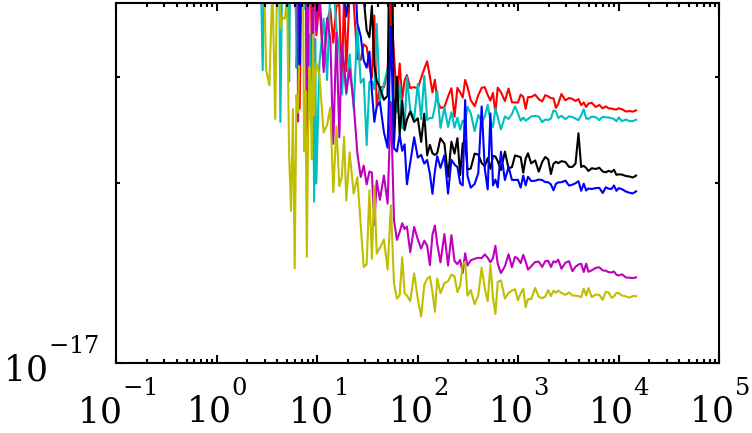

In [6]:
res = 0
s40 = ss40[res]
s32 = ss32[res]
s28 = ss28[res]
s24 = ss24[res]
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-17, 4e-17)
ax.plot(s40.S_frequency, s40.S_xx)
ax.plot(s40.S_frequency, s40.S_yy)
ax.plot(s32.S_frequency, s32.S_xx)
ax.plot(s32.S_frequency, s32.S_yy)
ax.plot(s28.S_frequency, s28.S_xx)
ax.plot(s28.S_frequency, s28.S_yy)
ax.plot(s24.S_frequency, s24.S_xx)
ax.plot(s24.S_frequency, s24.S_yy)

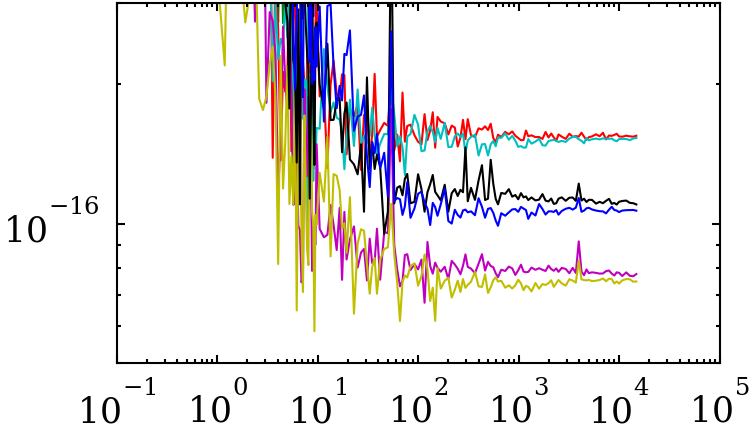

In [50]:
res = 4
s40 = ss40[res]
s32 = ss32[res]
s28 = ss28[res]
s24 = ss24[res]
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')

ax.plot(s40.S_frequency, s40.S_xx)
ax.plot(s40.S_frequency, s40.S_yy)
ax.plot(s32.S_frequency, s32.S_xx)
ax.plot(s32.S_frequency, s32.S_yy)
ax.plot(s28.S_frequency, s28.S_xx)
ax.plot(s28.S_frequency, s28.S_yy)
ax.plot(s24.S_frequency, s24.S_xx)
ax.plot(s24.S_frequency, s24.S_yy)

ax.set_ylim(5e-17, 3e-16);

In [8]:
s24.stream.roach_state.dac_attenuation

24.0

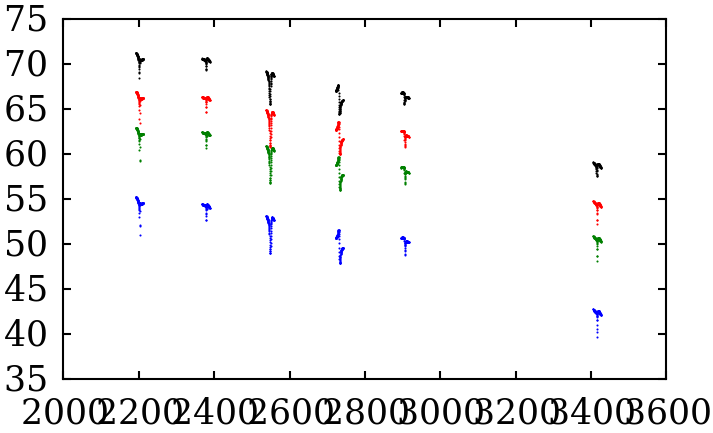

In [14]:
fig, ax = plt.subplots()
for s in ss40:
    ax.plot(s.sweep.frequency_MHz, 20 * np.log10(np.abs(s.sweep.s21_point)), '.b', markersize=1)
for s in ss32:
    ax.plot(s.sweep.frequency_MHz, 20 * np.log10(np.abs(s.sweep.s21_point)), '.g', markersize=1)
for s in ss28:
    ax.plot(s.sweep.frequency_MHz, 20 * np.log10(np.abs(s.sweep.s21_point)), '.r', markersize=1)
for s in ss24:
    ax.plot(s.sweep.frequency_MHz, 20 * np.log10(np.abs(s.sweep.s21_point)), '.k', markersize=1)

In [27]:
[1e-9 * s.resonator.f_0 for s in ss24]

[2.2011086010983685,
 2.3785735280677871,
 2.5484479053649358,
 2.7302879021776509,
 2.9040847791387403,
 3.4149924016786173]

In [17]:
df = pd.concat(s.to_dataframe() for s in ss40 + ss32 + ss28 + ss24)

In [18]:
df.shape

(24, 51)

In [19]:
df[df.roach_dac_attenuation==24].shape

(6, 51)

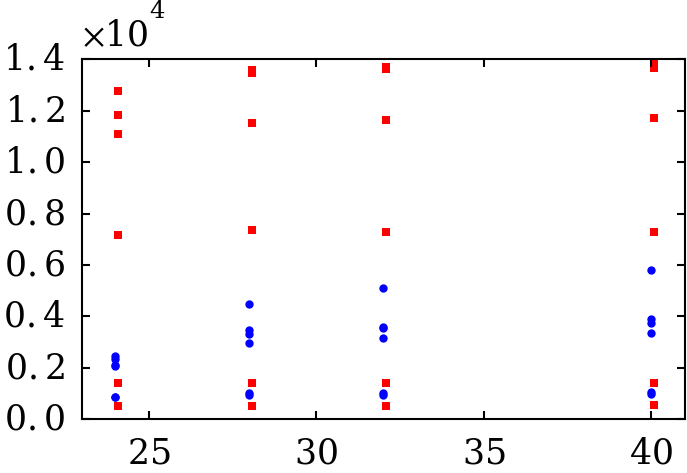

In [20]:
fig, ax = plt.subplots()
ax.set_xlim(23, 41)
ax.plot(df.roach_dac_attenuation, df.res_Q_i, 'ob', ms=2)
ax.plot(df.roach_dac_attenuation + 0.1, df.res_Q_e_real, 'sr', ms=2)


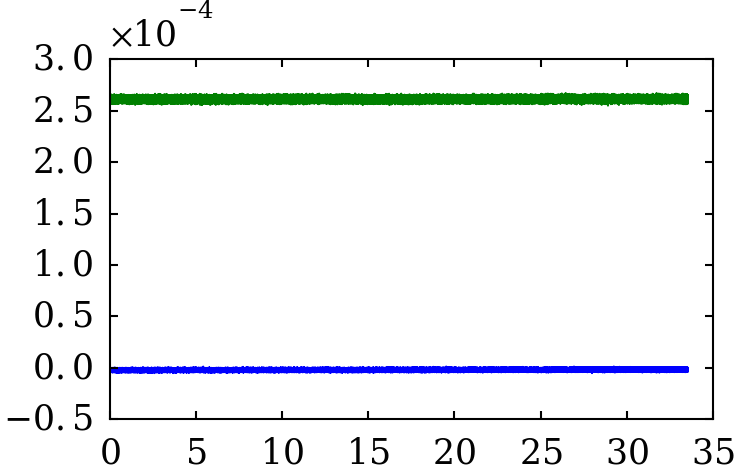

In [21]:
s = ss32[0]
fig, ax = plt.subplots()
ax.plot(s.stream.sample_time, s.x, '-')
ax.plot(s.stream.sample_time, s.q, '-')

In [22]:
decimate = 256
nyquist = s.S_frequency.max()
x = filters.low_pass_fir(s.x, cutoff=nyquist / decimate, nyquist_freq=nyquist, decimate_by=decimate)

/home/flanigan/readout/kid_readout/kid_readout/analysis/timedomain/fftfilt.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i:k] = y[i:k] + yt[:k-i]            # and add


In [23]:
np.log2(s.x.size)

20.0

In [24]:
# low_pass_fir isn't decimating as I'd expect, so I have to pad
pad = 1
np.log2(x.size+pad)

12.0

In [33]:
sqrt_decimate = 16
dx = signal.decimate(signal.decimate(s.x, sqrt_decimate, ftype='fir'), sqrt_decimate, ftype='fir')

(-3, 3)

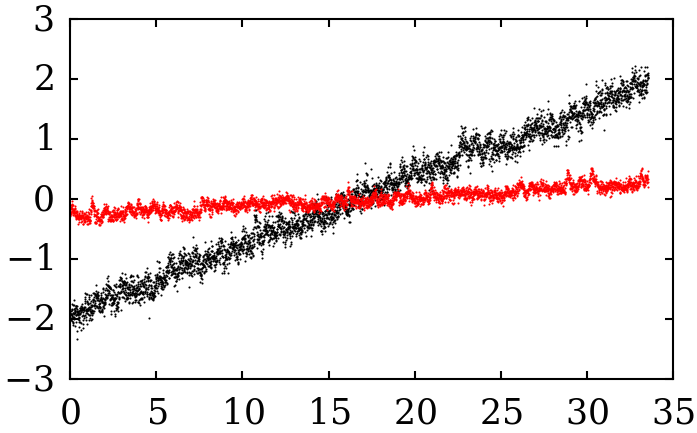

In [41]:
fig, ax = plt.subplots()
#ax.plot(s.stream.sample_time, 1e6 * s.x, ',')
ax.plot(s.stream.sample_time[::sqrt_decimate**2], 1e6 * (dx - dx.mean()), '.k', ms=1)
ax.plot(s.stream.sample_time[::decimate][:-pad], 1e6 * (x - x.mean()), '.r', ms=1)
ax.set_ylim(-3, 3)
